![logo](https://www.tec.ac.cr/sites/default/files/media/branding/logo-tec.png "TEC")

# Big Data, Programa de Ciencia de los Datos
## Tarea #3

* **Esteban Sáenz Villalobos** (**esaenz7@gmail.com**)
* Entrega: 29 de agosto 2021, 23:00.
* Observaciones: Trabajo elaborado desde Google Colab. Ejecutar cada celda de código de forma secuencial.


## Objetivo
EjecutarelprocesodeextraccióndedatosyentrenamientodeunmodeloenApacheSparkdeprincipio a fin.

## Resultados esperados para esta asignación
Para esta asignación los estudiantes deberán entregar un Jupyter Notebook donde se entrene un modelo de clasificación binaria, basada en algún conjunto de datos de su escogencia (e.g. conjuntos de kaggle).

El notebook deberá ser autocontenido en su ejecución y análisis de resultados, utilizando una instancia de postgresql como apoyo, ejecutada a través de un contenedor, como hemos hecho hasta el momento. El notebook deberá ejecutarse desde un contenedor Docker. Se espera que los estudiantes se basen en infraestructura Spark y no en código secuencial hecho en Python. El uso del framework será parte de lo evaluado en la asignación.

## Consideraciones generales

Para obtener el puntaje de cada uno de los rubros los estudiantes deberán mostrar suficiente información en la salida del Jupyter Notebook para demostrar que se cumple con lo pedido.
Como el Jupyter Notebook deberá correrse sobre un contenedor, deberá entregarse un archivo comprimido que contenga el análogo al repositorio con un Dockerfile, además de un PDF con todas las instrucciones necesarias para poder ejecutar exitosamente el código del Notebook.

---

## Código para Google Colab únicamente

In [9]:
'''
Instalación de PySpark en Colab
'''
from IPython.display import Javascript
##@title spark-submit programaestudiante.py { vertical-output: true, form-width: "50%", display-mode: "both" }
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 100})'''))
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import requests, os
from bs4 import BeautifulSoup
#obtener las versiones de spark e instalar la última disponile
soup = BeautifulSoup(requests.get('https://downloads.apache.org/spark/').text)
link_files = []
[link_files.append(link.get('href')) for link in soup.find_all('a')]
spark_link = [x for x in link_files if 'spark' in x]
ver_spark = spark_link[-1][:-1]
os.system(f"wget -q https://www-us.apache.org/dist/spark/{ver_spark}/{ver_spark}-bin-hadoop3.2.tgz")
os.system(f"tar xf {ver_spark}-bin-hadoop2.7.tgz")
#instalar pyspark
!pip install -q pyspark
!pip --version
!pyspark --version
!pip install findspark

<IPython.core.display.Javascript object>

pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
/usr/local/bin/pyspark: line 24: /usr/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: No such file or directory
/usr/local/bin/pyspark: line 68: /usr/lib/python3.7/site-packages/pyspark/bin/spark-submit: No such file or directory


## Datos de entrada (5 puntos)

Los estudiantes podrán seleccionar un conjunto de datos de su preferencia. Se espera que se provea una descripción de los datos, donde se detalle cuál es el dominio del problema y una descripción de los diferentes atributos en el conjunto. Debe incluir explícitamente cuál es la variable de predicción a utilizar.


In [33]:
'''
Carga de datos, librerías y sesión spark
'''

#descargar del archivo fuente
!pip install -q gdown
!gdown https://drive.google.com/uc?id=1dbLMJlEc_i_vGef1p4ZP1sfNTd00KBzX
!gdown https://drive.google.com/uc?id=1RnIhzhH0yBNVjneB9b1X37HmtEKrb_20

#librerías necesarias
import sys, os, glob, datetime as dt
import seaborn as sns, matplotlib.pyplot as plt
from pyspark.sql import SparkSession, functions as F, window as W, DataFrame as DF
from pyspark.sql.types import (DateType, IntegerType, FloatType, DoubleType, LongType, StringType, StructField, StructType, TimestampType)
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression
from functools import reduce

# import findspark
# findspark.init('/usr/lib/python3.7/site-packages/pyspark')

#sesión de spark
spark = SparkSession.builder\
  .master("local")\
  .appName("App#1")\
  .config('spark.ui.port', '4050')\
  .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
  .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
  .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Downloading...
From: https://drive.google.com/uc?id=1dbLMJlEc_i_vGef1p4ZP1sfNTd00KBzX
To: /content/6 class csv.csv
100% 8.48k/8.48k [00:00<00:00, 15.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RnIhzhH0yBNVjneB9b1X37HmtEKrb_20
To: /content/Star3642_balanced.csv
100% 140k/140k [00:00<00:00, 52.9MB/s]


## Preprocesamiento de datos

Similar al protocolo visto en clase, la primera fase deberá leer y ajustar los datos previo a la fase de entrenamiento. Se espera que los estudiantes cumplan con:

  * Cargado y limpieza de datos de archivo de entrada CSV. Esto implica la definición del "schema" y muestras en el notebook que los datos se han cargado exitosamente (5 puntos).
  * Gráficos y estadísticas descriptivas previo al entrenamiento. Se espera que los estudiantes muestren estadísticas descriptivas, correlaciones, etc. Ésto con el fin de entender el conjunto de datos (10 puntos).
  * Normalización / Estandarización. Los estudiantes deberán seleccionar alguna estrategia para mitigar los problemas de escala que pueden tener las diferentes columnas del modelo (10 puntos).
  * Escritura a base de datos. Una vez que los datos hayan sido depurados se espera que los estudiantes escriban a una tabla llamada tarea3 (con overwrite) el conjunto de datos que se utilizará como base para el entrenamiento. Los estudiantes deberán documentar en detalle cualquier instrucción necesaria para poder calificar esta sección. Los datos escritos en la base de datos no podrán estar almacenados en forma de vector. Deben ser extraídos a columnas individuales (10 puntos).


In [12]:
'''
Lectura de datos
'''

df_stars = spark \
  .read \
  .format('csv') \
  .option('path', 'Star3642_balanced.csv') \
  .option('header', True) \
  .schema(StructType([
          StructField("vmag", FloatType()),
          StructField("plx", FloatType()),
          StructField("eplx", FloatType()),
          StructField("bv", FloatType()),
          StructField("sptype", StringType()),
          StructField("amag", FloatType()),
          StructField("class", IntegerType())])) \
  .load()

df_stars.printSchema()
df_stars.show()

root
 |-- vmag: float (nullable = true)
 |-- plx: float (nullable = true)
 |-- eplx: float (nullable = true)
 |-- bv: float (nullable = true)
 |-- sptype: string (nullable = true)
 |-- amag: float (nullable = true)
 |-- class: integer (nullable = true)

+----+-----+----+------+---------+---------+-----+
|vmag|  plx|eplx|    bv|   sptype|     amag|class|
+----+-----+----+------+---------+---------+-----+
|5.99|13.73|0.58| 1.318|    K5III|16.678352|    0|
| 8.7| 2.31|1.29|-0.045|     B1II| 15.51806|    0|
|5.77|  5.5|1.03| 0.855|    G5III|14.471813|    0|
|6.72| 5.26|0.74|-0.015|      B7V|15.324928|    1|
|8.76|13.44|1.16| 0.584|      G0V|19.401997|    1|
| 4.9| 8.37|0.76|-0.091|    B9III|14.513628|    0|
| 8.6| 5.09|1.37| 0.448|      F3V|17.133589|    1|
|6.24| 8.08|1.15|  0.68|    G0III|15.777057|    0|
|7.31| 1.86|0.87| 1.164| K0/K1III|13.657564|    0|
|9.52| 1.28|1.33|   1.5|    K2III| 15.05605|    0|
|6.18| 5.93| 0.7| 1.467|    K4III|15.045273|    0|
|7.57| 8.67|0.84| 0.528|      F8

In [13]:
#subconjunto de interés
df1 = df_stars
cols = ['vmag', 'plx', 'bv', 'amag', 'class']
df1 = df_stars.select(cols)
df1.show()

+----+-----+------+---------+-----+
|vmag|  plx|    bv|     amag|class|
+----+-----+------+---------+-----+
|5.99|13.73| 1.318|16.678352|    0|
| 8.7| 2.31|-0.045| 15.51806|    0|
|5.77|  5.5| 0.855|14.471813|    0|
|6.72| 5.26|-0.015|15.324928|    1|
|8.76|13.44| 0.584|19.401997|    1|
| 4.9| 8.37|-0.091|14.513628|    0|
| 8.6| 5.09| 0.448|17.133589|    1|
|6.24| 8.08|  0.68|15.777057|    0|
|7.31| 1.86| 1.164|13.657564|    0|
|9.52| 1.28|   1.5| 15.05605|    0|
|6.18| 5.93| 1.467|15.045273|    0|
|7.57| 8.67| 0.528|17.260096|    1|
|7.58| 3.47| 1.626|15.281647|    0|
|8.27| 1.62| 0.146|14.317575|    1|
|9.03| 0.24| 1.106|10.931056|    1|
|9.79| 3.91| 0.711|17.750885|    1|
|8.69| 1.97| 1.444|15.162331|    0|
| 9.1| 7.46| 0.417|18.463696|    1|
|9.26|16.85| 0.831|   20.393|    1|
|9.72|14.49| 0.845|20.525341|    1|
+----+-----+------+---------+-----+
only showing top 20 rows



In [ ]:
#almacenamiento en base de datos
# df1 \
#   .write \
#   .format("jdbc") \
#   .mode('overwrite') \
#   .option("url", "jdbc:postgresql://127.0.0.1:5433/postgres") \
#   .option("user", "postgres") \
#   .option("password", "testPassword") \
#   .option("dbtable", "stars") \
#   .save()

In [14]:
#lectura desde base de datos
# df2 = spark \
#   .read \
#   .format("jdbc") \
#   .option("url", "jdbc:postgresql://127.0.0.1:5433/postgres") \
#   .option("user", "postgres") \
#   .option("password", "testPassword") \
#   .option("dbtable", "stars") \
#   .load()
df2 = df1
# df2.show()

In [17]:
#descripción del dataframe
df2.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|              vmag|               plx|                bv|              amag|             class|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|              3642|              3642|              3642|              3642|              3642|
|   mean|  8.12052992873307| 7.606153198425801|0.8270768809731871|16.427387719623077|               0.5|
| stddev|1.3388753563000517|11.924051891030755|0.4366988208080772|2.4281438146202325|0.5000686577414831|
|    min|              0.45|             -6.82|            -0.196|         2.8200002|                 0|
|    max|             12.49|            280.27|              2.53|         29.249165|                 1|
+-------+------------------+------------------+------------------+------------------+------------------+



In [23]:
#vectorización
dfassy = VectorAssembler(
  inputCols=['vmag', 'plx', 'bv', 'amag'],
  outputCol='features')

dfvec = dfassy.transform(df2)
dfvec = dfvec.select(['features', 'class'])
dfvec.show(truncate=False)

+-----------------------------------------------------------------------------+-----+
|features                                                                     |class|
+-----------------------------------------------------------------------------+-----+
|[5.989999771118164,13.729999542236328,1.3179999589920044,16.67835235595703]  |0    |
|[8.699999809265137,2.309999942779541,-0.04500000178813934,15.518059730529785]|0    |
|[5.769999980926514,5.5,0.8550000190734863,14.471813201904297]                |0    |
|[6.71999979019165,5.260000228881836,-0.014999999664723873,15.324928283691406]|1    |
|[8.760000228881836,13.4399995803833,0.5839999914169312,19.401996612548828]   |1    |
|[4.900000095367432,8.369999885559082,-0.09099999815225601,14.513628005981445]|0    |
|[8.600000381469727,5.090000152587891,0.4480000138282776,17.133588790893555]  |1    |
|[6.239999771118164,8.079999923706055,0.6800000071525574,15.777056694030762]  |0    |
|[7.309999942779541,1.8600000143051147,1.1640000343322

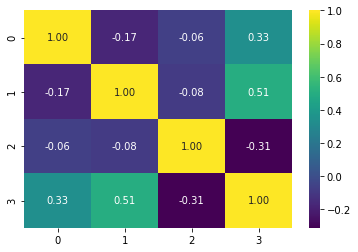

In [30]:
#correlaciones
pearson_matrix = Correlation.corr(dfvec, 'features').collect()[0][0]
sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='viridis')

In [32]:
#estandarización
standard_scaler = StandardScaler(inputCol='features', outputCol='scaled')
scale_model = standard_scaler.fit(dfvec)
dfscaled = scale_model.transform(dfvec)
dfscaled.show()

+--------------------+-----+--------------------+
|            features|class|              scaled|
+--------------------+-----+--------------------+
|[5.98999977111816...|    0|[4.47390396942653...|
|[8.69999980926513...|    0|[6.49799084606902...|
|[5.76999998092651...|    0|[4.30958711262844...|
|[6.71999979019165...|    1|[5.01913771029605...|
|[8.76000022888183...|    1|[6.54280489043421...|
|[4.90000009536743...|    0|[3.65978809925104...|
|[8.60000038146972...|    1|[6.42330172185378...|
|[6.23999977111816...|    0|[4.66062784840722...|
|[7.30999994277954...|    0|[5.45980617865769...|
|[9.52000045776367...|    0|[7.11044565348633...|
|[6.17999982833862...|    0|[4.61581416018956...|
|[7.57000017166137...|    1|[5.65399918374842...|
|[7.57999992370605...|    0|[5.66146795371093...|
|[8.27000045776367...|    1|[6.17682625858288...|
|[9.02999973297119...|    1|[6.74446630933992...|
|[9.78999996185302...|    1|[7.31210707239204...|
|[8.6899995803833,...|    0|[6.49052171995897...|


## Entrenamiento de modelos

Se deberá cargar de la base de datos el conjunto de datos limpio y se deberá entrenar dos modelos de clasificación (a escoger por los estudiantes). Se espera que se utilice el protocolo estándar de k-fold cross validation además de dejar un conjunto adicional para validación final.

  * Uso de protocolo K-fold cross validation, apoyándose en funciones Spark (10 puntos).
  * Entrenamiento de dos modelos (10 cada uno)-
    * En este rubro se incluye analizar métricas sobre el conjunto de datos de entrenamiento (en la siguiente sección se evalúa el conjunto de validación).


In [34]:
#regresión lineal
regression = LinearRegression(featuresCol='scaled', labelCol='class')
regression_model = regression.fit(dfscaled)

print('Pesos: {}\n b: {}'.format(regression_model.coefficients, regression_model.intercept))
print('RMSE: {} r2: {}'.format(regression_model.summary.rootMeanSquaredError, regression_model.summary.r2))

dfscaled.describe().show()

# Si se quiere hacer predicciones nada más se requiere llamar a regression_model.transform(df)
# Esto regresa el dataset con una columna nueva

Pesos: [0.0733932751520145,0.05874305072998934,-0.24959025456685685,0.15801420379219885]
 b: -0.5789395993959092
RMSE: 0.3301028273121496 r2: 0.5641284936021005
+-------+------------------+
|summary|             class|
+-------+------------------+
|  count|              3642|
|   mean|               0.5|
| stddev|0.5000686577414831|
|    min|                 0|
|    max|                 1|
+-------+------------------+



## Evaluación de conjunto de validación

Para cada uno de los modelos se espera que los estudiantes los evalúen y generen una predicción persistente en base de datos. Como evaluaremos dos modelos deberá crearse tablas llamadas modelo1 y modelo2 (con overwrite) en la base de datos, que tendrán las mismas columnas que tarea3 con una adicional llamada prediccion, que mostrará el resultado predicho de cada modelo.

Además, deberá mostrarse un análisis de resultados dentro del notebook para cada modelo, comparando los resultados de cada uno.

  * Evaluación y almacenado de modelo1 (10 puntos).
  * Evaluación y almacenado de modelo2 (10 puntos).
  * Análisis de resultados (10 puntos).


---